In [1]:
path_15_original = "../eval_outputs/triviaqa_Qwen2.5-1.5B-Instruct_validation_None_threshold.tsv"
path_15_trained = "../eval_outputs/triviaqa_qwen1.5-prompt2_iter300_validation_None_threshold.tsv"

path_3_original = "../eval_outputs/triviaqa_Qwen2.5-3B-Instruct_validation_None_threshold.tsv"
path_3_trained = "../eval_outputs/triviaqa_qwen3-prompt2_iter300_validation_None_threshold.tsv"

path_7_original = "../eval_outputs/triviaqa_Qwen2.5-7B-Instruct_validation_None_threshold.tsv"
path_7_trained = "../eval_outputs/triviaqa_qwen7-prompt2_iter300_validation_None_threshold.tsv"

In [2]:
import matplotlib
import pandas as pd

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

df = pd.read_csv(path_15_trained, sep="\t")
# df.head()

In [3]:
correctness = df["direct_correctness"]
confidence = df["confidence"]

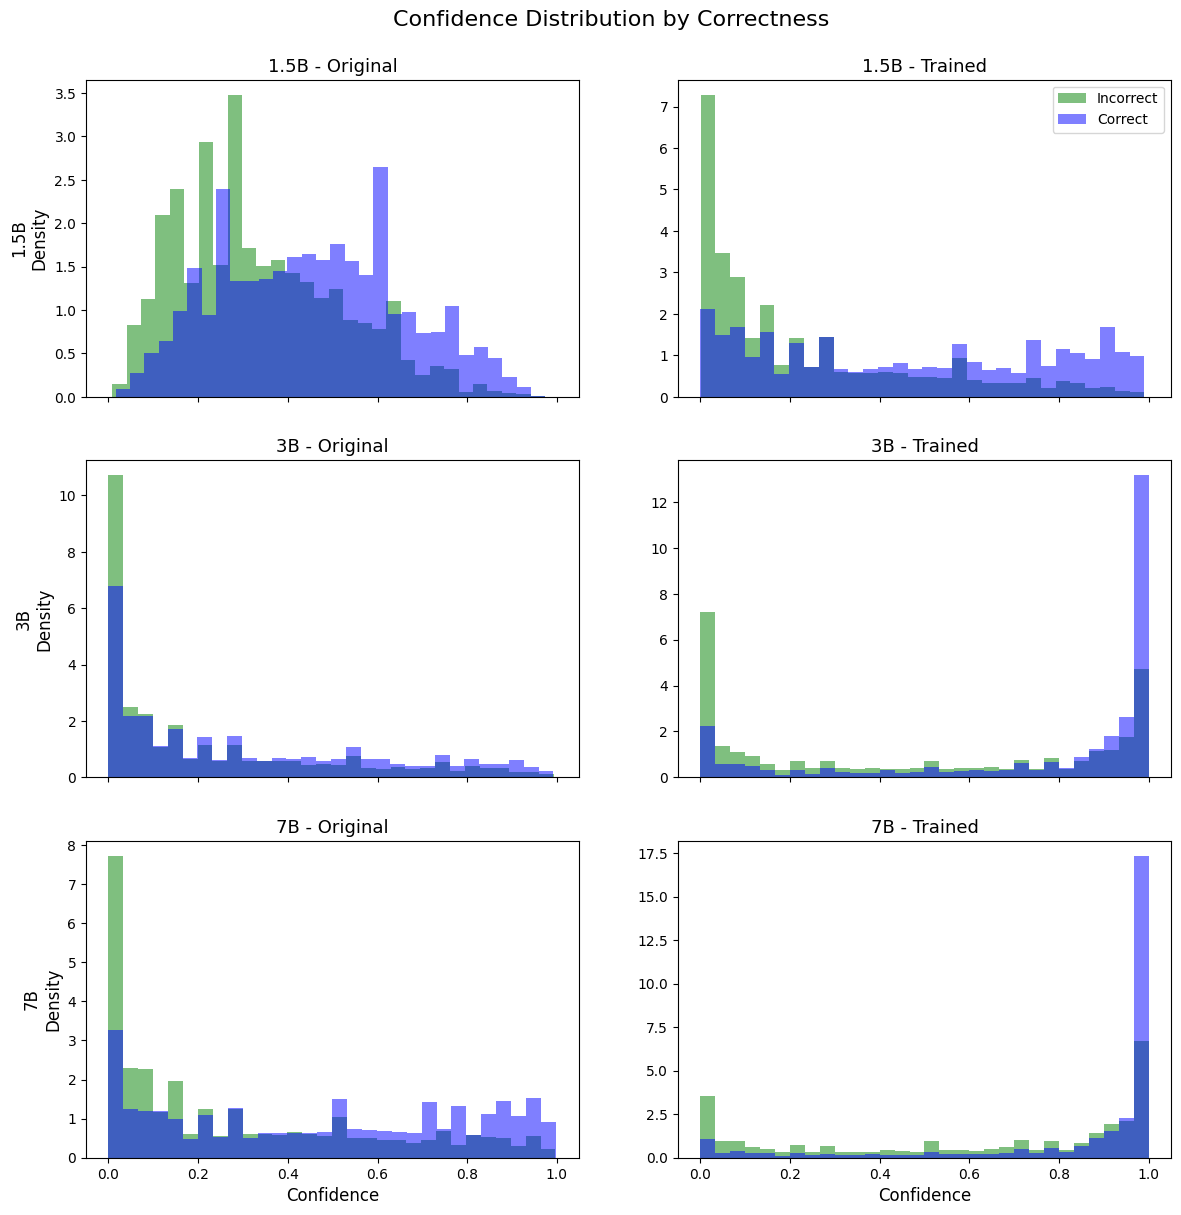

In [9]:
import matplotlib.pyplot as plt

# To plot 6 subplots:
# Row 1: 1.5B (left=original, right=trained)
# Row 2: 3B
# Row 3: 7B

model_info = [
    ("1.5B", path_15_original, path_15_trained),
    ("3B", path_3_original, path_3_trained),
    ("7B", path_7_original, path_7_trained),
]

fig, axes = plt.subplots(3, 2, figsize=(14, 14), sharex=True)

for row, (model_name, original_path, trained_path) in enumerate(model_info):
    for col, (version, path) in enumerate([('Original', original_path), ('Trained', trained_path)]):
        df_tmp = pd.read_csv(path, sep="\t")
        correctness = df_tmp["direct_correctness"]
        confidence = df_tmp["confidence"]
        correct_conf = confidence[correctness == 1]
        incorrect_conf = confidence[correctness == 0]

        ax = axes[row, col]
        ax.hist(incorrect_conf, bins=30, alpha=0.5, label='Incorrect', color='green', density=True)
        ax.hist(correct_conf, bins=30, alpha=0.5, label='Correct', color='blue', density=True)
        if col == 0:
            ax.set_ylabel(f"{model_name}\nDensity", fontsize=12)
        if row == 2:
            ax.set_xlabel('Confidence', fontsize=12)
        ax.set_title(f"{model_name} - {version}", fontsize=13)
        if row == 0 and col == 1:
            ax.legend(loc='upper right')

plt.suptitle('Confidence Distribution by Correctness', fontsize=16, y=0.93)
# plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('figures/confidence-distribution.pdf', dpi=300, transparent=True, bbox_inches='tight', format='pdf')
plt.show()
